# GSM8K pre-train vs RL evaluation visualization

Use this notebook to collect GSM8K evaluation scores from pre-training and RL runs under `/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results`, then plot how RL fine-tuning moves performance from its starting checkpoint.



In [1]:
from pathlib import Path
import re
import ast
import pandas as pd
import matplotlib.pyplot as plt

# Root location for evaluation outputs and the metric key to read
BASE_DIR = Path("/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results")
DATASET_KEY = "test_score/openai/gsm8k"

print(f"Base directory: {BASE_DIR}")



Base directory: /n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results


In [2]:
def read_score(result_path: Path, samples: int, dataset_key: str = DATASET_KEY):
    """Read score from either dict-style logs or majority-vote text.

    Returns:
        dict[int, float]: Dictionary mapping k values to scores.
                         For majority files, returns all Pass@k values found.
                         For dict-style files, returns {samples: score}.
                         Returns {} if no scores found.
    """
    if not result_path.exists():
        return {}

    text = result_path.read_text().splitlines()

    # Majority-format text file (pass@k, single-sample accuracy, etc.)
    if samples > 1 or "majority" in result_path.name:
        scores = {}
        for line in text:
            if "Pass@" in line and ":" in line:
                # Expect formats like: "  Pass@1 : 0.0403 (4.03%)" or "Pass@32 (Any Correct):  0.6884 (68.84%)"
                # Extract k value and score
                import re as _re
                # Match "Pass@<k>" pattern
                k_match = _re.search(r"Pass@(\d+)", line)
                if k_match:
                    k = int(k_match.group(1))
                    # Extract score after the colon
                    parts = line.split(":")
                    if len(parts) > 1:
                        try:
                            score = float(parts[1].split()[0])
                            scores[k] = score
                        except Exception:
                            pass
        if scores:
            return scores
        # If we didn't find Pass@, fall back to the dict parsing below

    # Dict-style log: scan from the bottom for a dict containing the key
    for line in reversed(text):
        try:
            payload = ast.literal_eval(line.strip())
        except Exception:
            continue
        if isinstance(payload, dict) and dataset_key in payload:
            return {samples: payload[dataset_key]}
    return {}

# Collect pre-train runs (pattern: 1B-step{step}-{shot}shot-{samples}samples-temp{temp})
pretrain_rows = []
pre_pattern = re.compile(r"1B-step(?P<step>\d+)-(?P<shot>\d+)shot-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$")

# Collect RL runs from both naming schemes below
#   1) 1B-step{pt_step}-rl-step{rl_step}-0shot-boxed-{samples}samples-temp{temp}
#   2) olmo2_1b_step{pt_step}_omigsm8k-step{rl_step}-rl-0shot-boxed-{samples}samples-temp{temp}
rl_rows = []
rl_patterns = [
    re.compile(r"1B-step(?P<pt_step>\d+)-rl-step(?P<rl_step>\d+)-0shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$"),
    re.compile(r"olmo2_1b_step(?P<pt_step>\d+)_omigsm8k-step(?P<rl_step>\d+)-rl-0shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$"),
    re.compile(r"olmo2_1b_step(?P<pt_step>\d+)_omigsm8k_n(?P<num_rollouts>\d+)-step(?P<rl_step>\d+)-rl-0shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$"),
]

# Collect SFT runs
#   1) 1B-step{pt_step}-sft-step{sft_step}-0shot-boxed-{samples}samples-temp{temp}
#   2) OLMo2-1B-step{pt_step}-stage2-openmathgsm8k-step{sft_step}-hf-{shot}shot-{samples}samples-temp{temp}
sft_rows = []
sft_patterns = [
    re.compile(r"OLMo2-1B-step(?P<pt_step>\d+)-stage2-openmathgsm8k-step(?P<sft_step>\d+)-hf-(?P<shot>\d+)shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$", re.IGNORECASE),
    re.compile(r"OLMo2-1B-step(?P<pt_step>\d+)-stage2-openmathgsm8k-5epoch-step(?P<sft_step>\d+)-hf-(?P<shot>\d+)shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$", re.IGNORECASE),
]

for path in BASE_DIR.iterdir():
    if not path.is_dir():
        continue
    name = path.name

    # Pre-train collection
    pre_match = pre_pattern.match(name)
    if pre_match and not any(tag in name for tag in ["-rl-", "-sft-", "-hf"]):
        samples = int(pre_match.group("samples"))
        result_file = "gsm8k_majority_results.txt" if samples > 1 else "gsm8k_results.txt"
        scores_dict = read_score(path / result_file, samples=samples)
        
        # Create a row for each k value found
        for k, score in scores_dict.items():
            pretrain_rows.append(
                {
                    "step": int(pre_match.group("step")),
                    "shot": int(pre_match.group("shot")),
                    "samples": k,  # Use the actual k value extracted from read_score
                    "temp": float(pre_match.group("temp")),
                    "score": score,
                    "path": str(path),
                }
            )
        continue

    # RL collection (first pattern that matches wins)
    matched = False
    for pat in rl_patterns:
        rl_match = pat.match(name)
        if rl_match:
            samples = int(rl_match.group("samples"))
            result_file = "gsm8k_majority_results.txt" if samples > 1 else "gsm8k_results.txt"
            scores_dict = read_score(path / result_file, samples=samples)
            pt_step = int(rl_match.group("pt_step"))
            rl_step = int(rl_match.group("rl_step"))
            num_rollouts = int(rl_match.group("num_rollouts")) if "num_rollouts" in rl_match.groupdict() and rl_match.group("num_rollouts") else 5
            
            # Create a row for each k value found
            for k, score in scores_dict.items():
                rl_rows.append(
                    {
                        "pt_step": pt_step,
                        "rl_step": rl_step,
                        "total_step": pt_step + rl_step,
                        "samples": k,  # Use the actual k value extracted from read_score
                        "temp": float(rl_match.group("temp")),
                        "num_rollouts": num_rollouts,
                        "score": score,
                        "path": str(path),
                        "label": name,
                    }
                )
            matched = True
            break
    if matched:
        continue

    # SFT collection (first pattern that matches wins)
    for pat in sft_patterns:
        sft_match = pat.match(name)
        if sft_match:
            samples = int(sft_match.group("samples"))
            shot = int(sft_match.group("shot")) if "shot" in sft_match.groupdict() else None
            result_file = "gsm8k_majority_results.txt" if samples > 1 else "gsm8k_results.txt"
            scores_dict = read_score(path / result_file, samples=samples)
            pt_step = int(sft_match.group("pt_step"))
            sft_step = int(sft_match.group("sft_step"))
            if "5epoch" in name:
                epochs = 5
            else:
                epochs = 1
            
            # Create a row for each k value found
            for k, score in scores_dict.items():
                sft_rows.append(
                    {
                        "pt_step": pt_step,
                        "sft_step": sft_step,
                        "total_step": pt_step + sft_step,
                        "shot": shot,
                        "samples": k,  # Use the actual k value extracted from read_score
                        "temp": float(sft_match.group("temp")),
                        "score": score,
                        "path": str(path),
                        "label": name,
                        "sft_epochs": epochs,
                    }
                )
            break

pre_df = pd.DataFrame(pretrain_rows)
rl_df = pd.DataFrame(rl_rows)
sft_df = pd.DataFrame(sft_rows)

print(f"Loaded {len(pre_df)} pre-train runs, {len(rl_df)} RL runs, {len(sft_df)} SFT runs.")

# Remove duplicates - keep first occurrence
print(f"Removing duplicates...")
pre_df_before = len(pre_df)
rl_df_before = len(rl_df)
sft_df_before = len(sft_df)

# Only drop duplicates if dataframe is not empty
if not pre_df.empty:
    pre_df = pre_df.drop_duplicates(subset=['step', 'shot', 'samples', 'temp'], keep='first')
if not rl_df.empty:
    rl_df = rl_df.drop_duplicates(subset=['pt_step', 'rl_step', 'samples', 'temp', 'num_rollouts'], keep='first')
if not sft_df.empty:
    sft_df = sft_df.drop_duplicates(subset=['pt_step', 'sft_step', 'samples', 'temp', 'shot', 'sft_epochs'], keep='first')

print(f"Pre-train: {pre_df_before} → {len(pre_df)} ({pre_df_before - len(pre_df)} duplicates removed)")
print(f"RL: {rl_df_before} → {len(rl_df)} ({rl_df_before - len(rl_df)} duplicates removed)")
print(f"SFT: {sft_df_before} → {len(sft_df)} ({sft_df_before - len(sft_df)} duplicates removed)")

Loaded 116 pre-train runs, 84 RL runs, 41 SFT runs.
Removing duplicates...
Pre-train: 116 → 116 (0 duplicates removed)
RL: 84 → 65 (19 duplicates removed)
SFT: 41 → 41 (0 duplicates removed)


In [3]:
display(pre_df.sort_values(["step", "shot", "samples", "temp"]))
print()
display(rl_df.sort_values(["pt_step", "rl_step", "samples", "temp", "num_rollouts"]))
print()
display(sft_df.sort_values(["pt_step", "sft_step", "samples", "temp"]))



,step,shot,samples,temp,score,path
1,1000,0,1,0.6,0.015163,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
3,1000,0,8,0.6,0.081100,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
2,1000,0,32,0.6,0.196400,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
0,1000,0,128,0.6,0.379100,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
5,1000,1,1,0.0,0.023503,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
...,...,...,...,...,...,...
61,22000,8,1,0.0,0.172858,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
62,22000,8,1,0.6,0.140258,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
64,22000,8,8,0.6,0.462500,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
63,22000,8,32,0.6,0.688400,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...


,pt_step,rl_step,total_step,samples,temp,num_rollouts,score,path,label
18,1000,400,1400,1,0.6,32,0.025019,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omigsm8k_n32-step400-rl-0sho...
20,1000,400,1400,8,0.6,32,0.109200,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omigsm8k_n32-step400-rl-0sho...
19,1000,400,1400,32,0.6,32,0.195600,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omigsm8k_n32-step400-rl-0sho...
21,1000,800,1800,1,0.6,32,0.025019,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omigsm8k_n32-step800-rl-0sho...
22,1000,800,1800,8,0.6,32,0.109200,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omigsm8k_n32-step800-rl-0sho...
...,...,...,...,...,...,...,...,...,...
40,22000,800,22800,8,0.6,5,0.713400,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omigsm8k-step800-rl-0shot-b...
45,22000,800,22800,8,0.6,32,0.724000,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omigsm8k_n32-step800-rl-0sh...
39,22000,800,22800,32,0.6,5,0.799800,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omigsm8k-step800-rl-0shot-b...
44,22000,800,22800,32,0.6,32,0.821800,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omigsm8k_n32-step800-rl-0sh...


,pt_step,sft_step,total_step,shot,samples,temp,score,path,label,sft_epochs
20,3000,285,3285,0,1,0.0,0.122820,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step3000-stage2-openmathgsm8k-step285...,1
17,3000,1389,4389,0,1,0.0,0.238817,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step3000-stage2-openmathgsm8k-5epoch-...,5
18,3000,1389,4389,0,1,0.6,0.188021,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step3000-stage2-openmathgsm8k-5epoch-...,5
19,3000,1389,4389,0,32,0.6,0.694500,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step3000-stage2-openmathgsm8k-5epoch-...,5
16,3000,1389,4389,0,128,0.6,0.860500,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step3000-stage2-openmathgsm8k-5epoch-...,5
26,5000,285,5285,0,1,0.0,0.197119,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step5000-stage2-openmathgsm8k-step285...,1
27,5000,285,5285,0,8,0.6,0.473100,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step5000-stage2-openmathgsm8k-step285...,1
22,5000,1389,6389,0,1,0.0,0.287339,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step5000-stage2-openmathgsm8k-5epoch-...,5
23,5000,1389,6389,0,1,0.6,0.255497,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step5000-stage2-openmathgsm8k-5epoch-...,5
25,5000,1389,6389,0,8,0.6,0.583800,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step5000-stage2-openmathgsm8k-5epoch-...,5


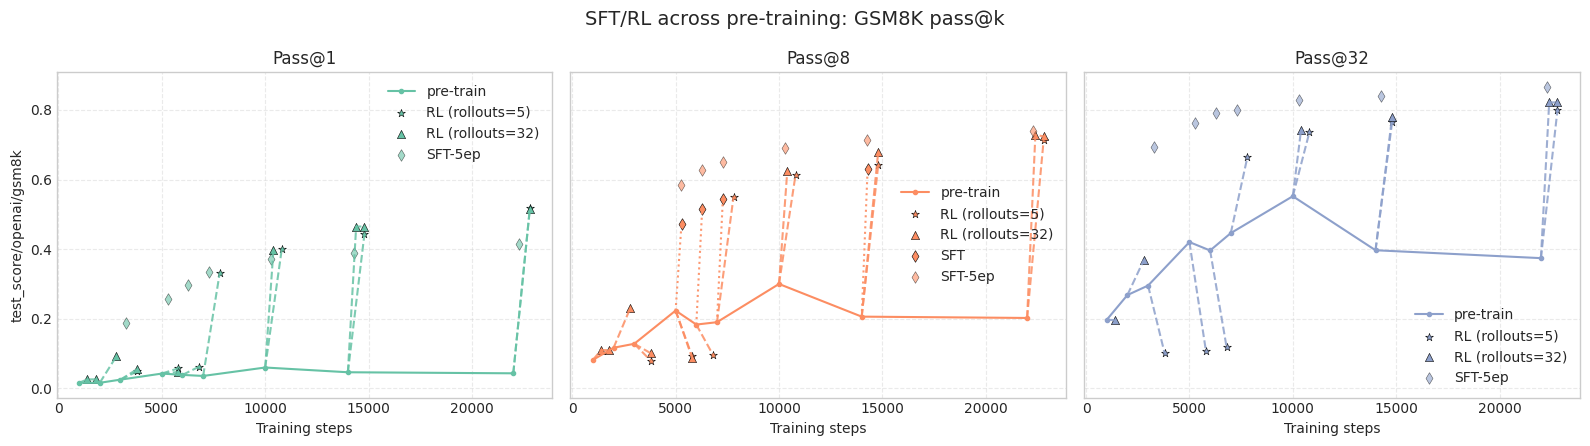

In [4]:
# Refined plotting: per-k subplots, cleaner legend markers, no RL/SFT marker at start
PLOT_SAMPLES = [1, 8, 32]
BASE_PRETRAIN_SHOT = 0
SHOT_BY_SAMPLES = lambda s: BASE_PRETRAIN_SHOT
TEMP_BY_SAMPLES = lambda s: 0.6

available_samples = sorted(set(pre_df["samples"]).union(rl_df["samples"]).union(sft_df["samples"]))
plot_samples = [s for s in PLOT_SAMPLES if s in available_samples]

plt.style.use("seaborn-v0_8-whitegrid")

if not plot_samples:
    fig, ax = plt.subplots(figsize=(20, 14))
    ax.text(0.5, 0.5, "No runs for the selected samples/temp", transform=ax.transAxes, ha="center")
    plt.show()
else:
    n = len(plot_samples)
    ncols = n  # 2 if n > 1 else 1
    nrows = 1  # (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4.5 * nrows), sharey=True)
    axes = axes.flatten() if n > 1 else [axes]
    cmap = plt.get_cmap("Set2")

    for idx, samples in enumerate(plot_samples):
        ax = axes[idx]
        target_temp = TEMP_BY_SAMPLES(samples)
        shot = SHOT_BY_SAMPLES(samples)
        color = cmap(idx % cmap.N)

        pre_curve = pre_df[(pre_df["samples"] == samples) & (pre_df["shot"] == shot) & (pre_df["temp"] == target_temp)].sort_values("step")
        if not pre_curve.empty:
            ax.plot(pre_curve["step"], pre_curve["score"], marker=".", color=color, label="pre-train")

        # RL: plot different curves for each num_rollouts
        rl_all = rl_df[(rl_df["samples"] == samples) & (rl_df["temp"] == target_temp)].sort_values(["num_rollouts", "pt_step", "rl_step"])
        unique_num_rollouts = sorted(rl_all["num_rollouts"].dropna().unique())
        # from matplotlib.cm import get_cmap
        # rl_cmap = get_cmap("tab10")
        for j, num_rollouts in enumerate(unique_num_rollouts):
            # subcolor = rl_cmap(j % rl_cmap.N)
            subset = rl_all[rl_all["num_rollouts"] == num_rollouts]
            rl_labeled = False
            for pt_step, group in subset.groupby("pt_step"):
                pre_match = pre_curve.loc[pre_curve["step"] == pt_step, "score"]
                start_score = pre_match.iloc[0] if not pre_match.empty else None
                group_sorted = group.sort_values("rl_step")
                xs = [pt_step] if start_score is not None else []
                ys = [start_score] if start_score is not None else []
                xs.extend((group_sorted["pt_step"] + group_sorted["rl_step"]).tolist())
                ys.extend(group_sorted["score"].tolist())
                if not xs:
                    continue
                label_rl = f"RL (rollouts={num_rollouts})" if not rl_labeled else None
                ax.plot(xs, ys, linestyle="--", marker=None, color=color, alpha=0.85)
                if len(xs) > 1:
                    ax.scatter(xs[1:], ys[1:], marker="*" if num_rollouts == 5 else "^", color=color, s=35, edgecolor="k", linewidth=0.4, label=label_rl)
                    rl_labeled = True

        # SFT standard
        sft_curve = sft_df[(sft_df.get("sft_epochs", "sft") == 1) & (sft_df["samples"] == samples) & (sft_df["temp"] == target_temp)].sort_values(["pt_step", "sft_step"])
        sft_labeled = False
        for pt_step, group in sft_curve.groupby("pt_step"):
            pre_match = pre_curve.loc[pre_curve["step"] == pt_step, "score"]
            start_score = pre_match.iloc[0] if not pre_match.empty else None
            group_sorted = group.sort_values("sft_step")
            xs = [pt_step] if start_score is not None else []
            ys = [start_score] if start_score is not None else []
            xs.extend((group_sorted["pt_step"] + group_sorted["sft_step"]).tolist())
            ys.extend(group_sorted["score"].tolist())
            if not xs:
                continue
            ax.plot(xs, ys, linestyle=":", marker=None, color=color, alpha=0.9)
            if len(xs) > 1:
                ax.scatter(xs[1:], ys[1:], marker="d", color=color, s=35, edgecolor="k", linewidth=0.4, label="SFT" if not sft_labeled else None)
                sft_labeled = True

        # SFT 5-epoch
        sft5_curve = sft_df[(sft_df.get("sft_epochs", "sft") == 5) & (sft_df["samples"] == samples) & (sft_df["temp"] == target_temp)].sort_values(["pt_step", "sft_step"])
        sft5_labeled = False
        for pt_step, group in sft5_curve.groupby("pt_step"):
            pre_match = pre_curve.loc[pre_curve["step"] == pt_step, "score"]
            start_score = pre_match.iloc[0] if not pre_match.empty else None
            group_sorted = group.sort_values("sft_step")
            xs = [pt_step] if start_score is not None else []
            ys = [start_score] if start_score is not None else []
            xs.extend((group_sorted["pt_step"] + group_sorted["sft_step"]).tolist())
            xs = [(pt_step + (x - pt_step)//5) for x in xs]
            ys.extend(group_sorted["score"].tolist())
            if not xs:
                continue
            # ax.plot(xs, ys, linestyle="-.", marker=None, color=color, alpha=0.9)
            if len(xs) > 1:
                ax.scatter(xs[1:], ys[1:], marker="d", color=color, s=35, edgecolor="k", linewidth=0.4, label="SFT-5ep" if not sft5_labeled else None, alpha=0.6)
                sft5_labeled = True

        ax.set_title(f"Pass@{samples}")
        ax.set_xlabel("Training steps")
        if idx % ncols == 0:
            ax.set_ylabel(DATASET_KEY)
        ax.grid(True, linestyle="--", alpha=0.4)
        ax.legend()

    fig.suptitle(f"SFT/RL across pre-training: GSM8K pass@k", fontsize=14)
    plt.tight_layout()
    plt.show()



In [ ]:
# fineweb-math for pre-training
# tiny-gsm numbers
# how back we can push the RL
# maybe we can push it way back and make up for pre-training but having to spend lot more FLOPs on RL
# poking around datasets

In [6]:
# Concise table with columns for pass@1/8/32/128 (pre, best SFT, best RL)
TARGET_KS = [1, 8, 32, 128]

rows = []
all_steps = sorted(pre_df["step"].unique().tolist())
for step in all_steps:
    row = {"pt_step": step}
    for k in TARGET_KS:
        temp = TEMP_BY_SAMPLES(k)
        shot = SHOT_BY_SAMPLES(k)

        pre_slice = pre_df[(pre_df["step"] == step) & (pre_df["samples"] == k) & (pre_df["temp"] == temp) & (pre_df["shot"] == shot)]
        row[f"pre_p{k}"] = pre_slice.iloc[-1]["score"] if not pre_slice.empty else None

        sft_slice = sft_df[(sft_df["pt_step"] == step) & (sft_df["samples"] == k) & (sft_df["temp"] == temp)]
        if not sft_slice.empty:
            best_sft = sft_slice.loc[sft_slice["total_step"].idxmax()]
            row[f"sft_p{k}"] = best_sft["score"]
            # row[f"sft_step{k}"] = best_sft["total_step"]
        else:
            row[f"sft_p{k}"] = None
            # row[f"sft_step{k}"] = None

        rl_slice = rl_df[(rl_df["pt_step"] == step) & (rl_df["samples"] == k) & (rl_df["temp"] == temp)]
        if not rl_slice.empty:
            best_rl = rl_slice.loc[rl_slice["total_step"].idxmax()]
            row[f"rl_p{k}"] = best_rl["score"]
            # row[f"rl_step{k}"] = best_rl["total_step"]
        else:
            row[f"rl_p{k}"] = None
            # row[f"rl_step{k}"] = None

    rows.append(row)

concise_df = pd.DataFrame(rows).sort_values("pt_step").reset_index(drop=True)
concise_df



,pt_step,pre_p1,sft_p1,rl_p1,pre_p8,sft_p8,rl_p8,pre_p32,sft_p32,rl_p32,pre_p128,sft_p128,rl_p128
0,1000,0.015163,NaN,0.025019,0.0811,NaN,0.1092,0.1964,NaN,0.1956,0.3791,NaN,NaN
1,2000,0.015163,NaN,0.090978,0.1160,NaN,0.2290,0.2676,NaN,0.3692,NaN,NaN,NaN
2,3000,0.024261,0.188021,0.053829,0.1274,NaN,0.0788,0.2949,0.6945,0.1001,0.5307,0.8605,0.1084
3,5000,0.041698,0.255497,0.046247,0.2229,0.5838,0.0910,0.4200,0.7627,0.1061,NaN,0.8893,0.1130
4,6000,0.037908,0.295679,0.061410,0.1827,0.6262,0.0963,0.3958,0.7923,0.1168,NaN,0.9052,0.1243
5,7000,0.034875,0.334344,0.330553,0.1895,0.6490,0.5497,0.4458,0.7991,0.6634,0.6854,0.9052,0.7945
6,10000,0.059136,0.370735,0.398787,0.2995,0.6914,0.6133,0.5519,0.8279,0.7354,NaN,0.9181,0.8249
7,14000,0.045489,0.389689,0.464746,0.2055,0.7149,0.6422,0.3965,0.8393,0.7786,0.5679,0.9265,0.8317
8,22000,0.042456,0.413950,0.514026,0.2017,0.7407,0.7134,0.3738,0.8658,0.7998,0.5466,0.9272,0.8787
